In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from transunet import TransUNet

In [4]:
class SegData(Dataset):

    def __init__(self,image_paths,mask_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')

        image = np.array(image)
        mask = np.array(mask)

        image = np.transpose(image,(2,0,1))

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Lambda(lambda x: x/torch.max(x)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        image = image.squeeze()
        mask = mask.squeeze()

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
        
        sample = {'image':image,'mask':mask}

        return sample

In [5]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
data_fold = [x.name for x in os.scandir(data_dir) if x.is_dir()]
data_fold.remove('.ipynb_checkpoints')

total_input_files = []
total_output_files = []
for fold in data_fold:
    fold_dir = os.path.join(data_dir,fold)
    for subfold in [x.name for x in os.scandir(os.path.join(data_dir,fold)) if (x.is_dir and x.name[0]!='.' and x.name!='Thumbs.db')]:
        subfold_dir = os.path.join(fold_dir,subfold)
        if subfold == 'images':
            total_input_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])
        elif subfold == 'masks':
            total_output_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])

In [6]:
# h_img,w_img = Image.open(total_input_files[0]).convert('RGB').size
# #get normalization values for the complete dataset
# red_sum = 0
# # blue_sum = 0
# # green_sum = 0
# # because orignal data is grey scale so values are distributed evenly across all three channels.
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = np_image[:,:,0].flatten()
#     # green_values = np_image[:,:,1].flatten()
#     # blue_values = np_image[:,:,2].flatten()

#     red_sum += np.sum(red_values)
#     # blue_sum += np.sum(blue_values)
#     # green_sum += np.sum(green_values)

#     del(red_values)
#     # del(green_values)
#     # del(blue_values)

# total_mean = [red_sum/(h_img*w_img*len(total_input_files))]*3

# red_std_sum = 0
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = (np_image[:,:,0].flatten() - total_mean[0])**2
#     red_std_sum += np.sum(red_values)

#     del(red_values)

# total_std = [math.sqrt(red_std_sum/(h_img*w_img*len(total_input_files)))]*3

In [7]:
from tqdm import tqdm

In [8]:
import gc

In [12]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    model = TransUNet(img_dim=128,
                          in_channels=3,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1)
    model.to(device)
    epochs = 10
    loss_func = torch.nn.BCEWithLogitsLoss()
    loss_func.to(device)
#     optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01,momentum = 0.9, weight_decay = 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-4)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_transunet')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=seed)
    train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    train_dataloader = DataLoader(train_data,batch_size = 8,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 8,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.unsqueeze(mask_final,1)
            #print(mask_final.shape)
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
            #break
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                

        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = batch['image'].to(device)
            final_mask = torch.unsqueeze(batch['mask'],1).to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
            #break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [ ]:
train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 0.27139
	Batch Loss for curent for 199 is 0.18830
	Batch Loss for curent for 299 is 0.16781
	Batch Loss for curent for 399 is 0.18179
	Batch Loss for curent for 499 is 0.16686
	Batch Loss for curent for 599 is 0.15789
	Batch Loss for curent for 699 is 0.15376
	Batch Loss for curent for 799 is 0.15047
	Batch Loss for curent for 899 is 0.14047
	Batch Loss for curent for 999 is 0.14640
	Batch Loss for curent for 1099 is 0.13656
	Batch Loss for curent for 1199 is 0.13719
	Batch Loss for curent for 1299 is 0.13912
	Batch Loss for curent for 1399 is 0.14299
	Batch Loss for curent for 1499 is 0.13080
	Batch Loss for curent for 1599 is 0.12957
	Batch Loss for curent for 1699 is 0.13041
	Batch Loss for curent for 1799 is 0.12230
	Batch Loss for curent for 1899 is 0.12601
	Batch Loss for curent for 1999 is 0.12376
	Batch Loss for curent for 2099 is 0.12813
The average loss for the epoch is 0.15094587650989438
The average validation loss for the epoch is 0

 10%|█         | 1/10 [09:55<1:29:15, 595.09s/it]

Epoch 2


In [ ]:
torch.cuda.empty_cache()

In [25]:
def diceScore(inputs, targets):
    # Calculate intersection and union for each sample in the batch
    epsilon = 1e-6
    intersection = torch.sum(inputs * targets, dim=(1, 2, 3))  # Sum over height, width, and channels
    total = torch.sum(inputs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))

    # Calculate Dice coefficient with epsilon for numerical stability
    dice_coefficient = (2. * intersection + epsilon) / (total + epsilon)

    return torch.mean(dice_coefficient)

In [29]:
# visualize the mask outputs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=13)
#     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
model_vis = TransUNet(img_dim=128,
                      in_channels=3,
                      out_channels=128,
                      head_num=4,
                      mlp_dim=512,
                      block_num=8,
                      patch_dim=16,
                      class_num=1)
model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_transunet/weigths/best_epoch8'
model_vis.load_state_dict(torch.load(model_vis_path))
model_vis.to(device)
model_vis.eval()
dice_scores = []

test_dataloader = DataLoader(valid_data,batch_size = 1,shuffle = True,pin_memory = True)
threshold = 0.5
for k,batch in enumerate(test_dataloader):
    final_image = batch['image'].to(device)
    final_mask = torch.unsqueeze(batch['mask'],1)

    pred = model_vis.forward(final_image)
    pred = torch.sigmoid(pred).cpu().detach()
    pred_score = torch.where(pred>0.5,torch.tensor(1),torch.tensor(0))
    dice_score = diceScore(pred_score,final_mask)
    dice_scores.append(dice_score.item())

print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))

The average dice score is 0.960593689193462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'binary output')

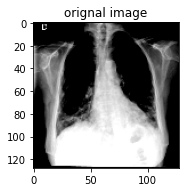

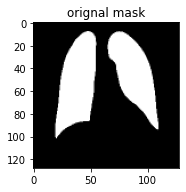

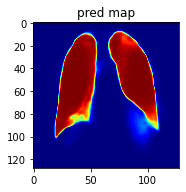

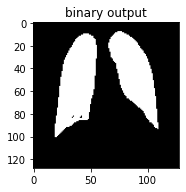

In [30]:
final_image_show = torch.squeeze(final_image).cpu().detach().numpy()
final_image_transpose = np.transpose(final_image_show,(1,2,0))
                                
final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

pred_image_transpose = torch.squeeze(pred).cpu().detach().numpy()
                                
bin_image_transpose = torch.squeeze(pred_score).cpu().detach().numpy()
                                
                                
plt.figure(figsize = (12,4))
plt.subplot(1,4,1)
plt.imshow(final_image_transpose)
plt.title('orignal image')

plt.figure(figsize = (12,4))
plt.subplot(1,4,2)
plt.imshow(final_mask_transpose,cmap = 'gray')
plt.title('orignal mask')

plt.figure(figsize = (12,4))
plt.subplot(1,4,3)
plt.imshow(pred_image_transpose,cmap = 'jet',vmin = 0, vmax = 1)
plt.title('pred map')

plt.figure(figsize = (12,4))
plt.subplot(1,4,4)
plt.imshow(bin_image_transpose,cmap = 'gray')
plt.title('binary output')

In [ ]:
total_mean

In [ ]:
total_std

In [ ]:
import pytorch_model_summary as pms

In [ ]:
model = Unet(3,1)

In [ ]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))